### Binary Classification Using Handcrafted Features and ML Classifiers

In [2]:
import torch
print(torch.__version__)  # Should print the installed version
print(torch.cuda.is_available())  # Should print False if using CPU-only PyTorch


2.5.1
False


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations: resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB channels
])

# Dataset path
dataset_path = "images/dataset"  # Change this if your dataset is in a different location

# Load dataset using ImageFolder (automatically assigns labels based on subfolders)
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Get class labels
print("Class Labels:", full_dataset.class_to_idx)  # {'mask': 0, 'nonmask': 1}

# Split dataset into train (80%) and test (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset size
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Class Labels: {'with_mask': 0, 'without_mask': 1}
Train size: 3276, Test size: 820


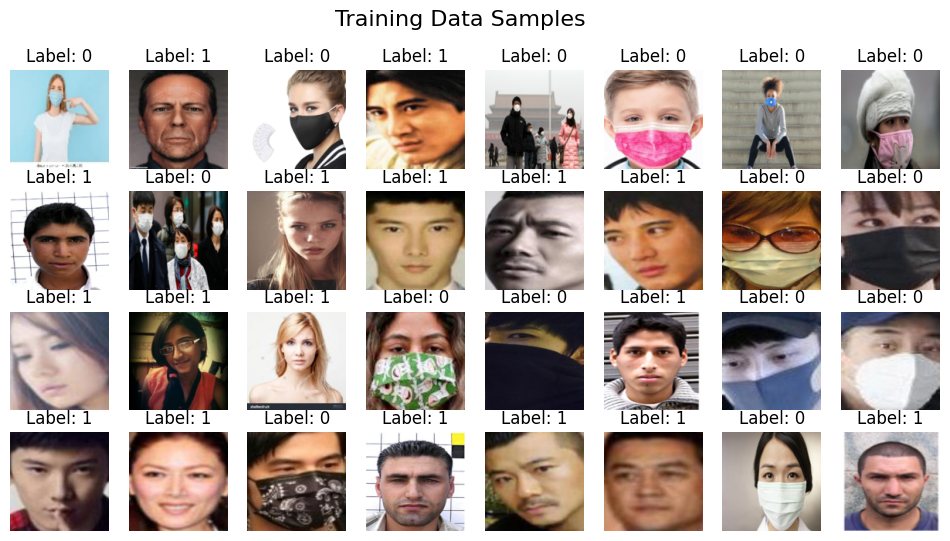

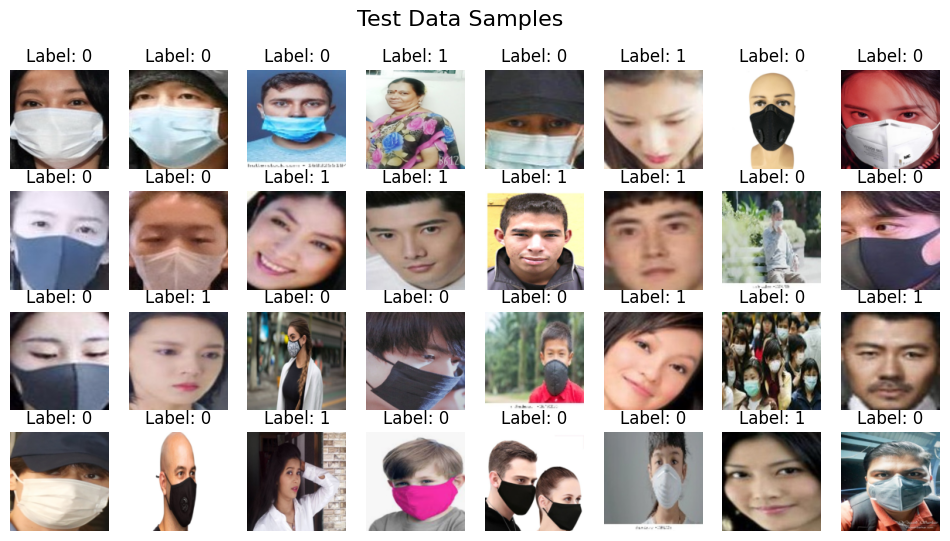

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a batch of images
def show_batch(data_loader, title):
    images, labels = next(iter(data_loader))  # Get a batch of images
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # 4 rows, 8 columns

    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            break
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy
        img = (img * 0.5) + 0.5  # Unnormalize
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

# Show some training images
show_batch(train_loader, "Training Data Samples")

# Show some test images
show_batch(test_loader, "Test Data Samples")


In [5]:
from torchvision import transforms  # Import transforms
from PIL import Image

# Function to Convert RGBA or Palette Images to RGB
def convert_rgba_to_rgb(image):
    if image.mode == "P":  # Convert palette-based images
        image = image.convert("RGBA")
    if image.mode == "RGBA":
        image = image.convert("RGB")  # Remove alpha channel
    return image

# Define Image Transformations
transform = transforms.Compose([
    transforms.Lambda(convert_rgba_to_rgb),  # Convert transparent images
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [6]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define transformations (Grayscale for feature extraction)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor()
])

# Dataset path
dataset_path = "images/dataset"  # Adjust as needed

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Extract labels
labels = np.array([label for _, label in full_dataset])

# Function to Extract HOG Features
def extract_hog_features(image_tensor):
    image = image_tensor.squeeze(0).numpy()  # Convert tensor to NumPy (Grayscale)
    features = hog(image, orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2), feature_vector=True)
    return features

# Extract HOG features for all images
features = np.array([extract_hog_features(img) for img, _ in full_dataset])

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Train Samples: {len(X_train)}, Test Samples: {len(X_test)}") 

C:\Users\HP\anaconda3\envs\myenv\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Samples: 3276, Test Samples: 820


In [7]:
import pandas as pd
import numpy as np

# Create a DataFrame for the HOG features of training data
train_features_df = pd.DataFrame(X_train)

# Create a DataFrame for the labels
train_labels_df = pd.DataFrame(y_train, columns=['Label'])

# Combine features and labels into a single DataFrame
train_df = pd.concat([train_features_df, train_labels_df], axis=1)

from IPython.display import display
display(train_df.head())  # Better table format in Jupyter


,0,1,2,3,4,5,6,7,8,9,...,8091,8092,8093,8094,8095,8096,8097,8098,8099,Label
0,0.064738,0.073480,0.184682,0.180735,0.163549,0.007619,0.021855,0.000000,0.031422,0.047702,...,0.299512,0.036236,0.015278,0.024157,0.032410,0.012079,0.114587,0.196224,0.185039,1
1,0.197991,0.124165,0.100777,0.258337,0.146132,0.022518,0.021086,0.008225,0.014428,0.380850,...,0.170587,0.072508,0.101367,0.199374,0.235833,0.047380,0.071083,0.013877,0.019625,1
2,0.164320,0.052184,0.200469,0.108589,0.116687,0.017395,0.066008,0.045443,0.000000,0.132246,...,0.410483,0.004984,0.005864,0.000000,0.015205,0.000000,0.000000,0.004984,0.017150,0
3,0.254203,0.148446,0.055444,0.040803,0.095212,0.105376,0.051876,0.055208,0.215176,0.254203,...,0.023830,0.219038,0.266008,0.329918,0.150003,0.000000,0.000000,0.000000,0.000000,1
4,0.030938,0.012394,0.204548,0.306020,0.306020,0.000000,0.000000,0.000000,0.000000,0.024063,...,0.066891,0.039810,0.031049,0.011028,0.028891,0.037271,0.023595,0.016151,0.021861,1


In [8]:
# Import required libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize SVM with a linear kernel (you can try 'rbf' or 'poly' too)
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Classification report for detailed performance analysis
print(classification_report(y_test, y_pred_svm))



SVM Accuracy: 0.8744
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       457
           1       0.84      0.89      0.86       363

    accuracy                           0.87       820
   macro avg       0.87      0.88      0.87       820
weighted avg       0.88      0.87      0.87       820



In [9]:
from sklearn.neural_network import MLPClassifier

# Initialize MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)

# Train MLP
mlp_classifier.fit(X_train, y_train)

# Predict on test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Evaluate MLP performance
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Accuracy: {accuracy_mlp:.4f}")

# Classification report
print(classification_report(y_test, y_pred_mlp))


MLP Accuracy: 0.8939
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       457
           1       0.87      0.90      0.88       363

    accuracy                           0.89       820
   macro avg       0.89      0.89      0.89       820
weighted avg       0.89      0.89      0.89       820



In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression model
log_reg_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg_classifier.predict(X_test)

# Evaluate performance
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")

# Classification report for detailed analysis
print(classification_report(y_test, y_pred_log_reg))


Logistic Regression Accuracy: 0.8829
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       457
           1       0.85      0.89      0.87       363

    accuracy                           0.88       820
   macro avg       0.88      0.88      0.88       820
weighted avg       0.88      0.88      0.88       820



In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")

# Classification report for detailed analysis
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.6939
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       457
           1       0.65      0.66      0.66       363

    accuracy                           0.69       820
   macro avg       0.69      0.69      0.69       820
weighted avg       0.69      0.69      0.69       820



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate model performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Display classification report
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8841
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       457
           1       0.91      0.82      0.86       363

    accuracy                           0.88       820
   macro avg       0.89      0.88      0.88       820
weighted avg       0.89      0.88      0.88       820



### Binary Classification Using CNN 

In [14]:
import torch
import torch.nn as nn  # Import PyTorch neural network module

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class FaceMaskCNN(nn.Module):
    def __init__(self):
        super(FaceMaskCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),  # Adjust based on input image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model and move to device (GPU if available)
model = FaceMaskCNN().to(device)


Using device: cpu


C:\Users\HP\anaconda3\envs\myenv\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Loss: 0.3354
Epoch 2/10, Loss: 0.2010
Epoch 3/10, Loss: 0.1749
Epoch 4/10, Loss: 0.1334
Epoch 5/10, Loss: 0.1066
Epoch 6/10, Loss: 0.0909
Epoch 7/10, Loss: 0.0782
Epoch 8/10, Loss: 0.0661
Epoch 9/10, Loss: 0.0462
Epoch 10/10, Loss: 0.0392


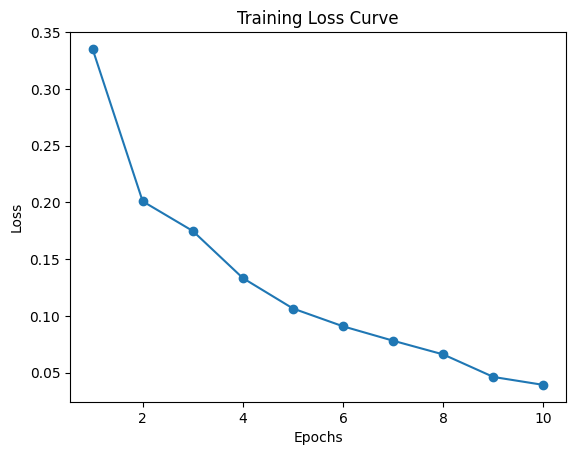

In [15]:
import torch.optim as optim  # Import optimizer module

# Loss function & Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Reshape labels
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Import matplotlib before plotting
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [16]:
# Function to evaluate model accuracy
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()  # Convert sigmoid outputs to 0 or 1
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate model
evaluate(model, test_loader)


Test Accuracy: 97.32%


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CNN class with Sigmoid activation for binary classification
class FaceMaskCNN(nn.Module):
    def __init__(self):
        super(FaceMaskCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Hyperparameter options
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
optimizers = ["Adam", "SGD", "RMSprop"]

# Store results
results = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"\nTraining with lr={lr}, batch_size={batch_size}, optimizer={opt}")

            # Create dataloaders with new batch size
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model
            model = FaceMaskCNN().to(device)

            # Define optimizer
            if opt == "Adam":
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt == "SGD":
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif opt == "RMSprop":
                optimizer = optim.RMSprop(model.parameters(), lr=lr)

            # Define loss function
            criterion = nn.BCELoss()

            # Train model
            num_epochs = 5
            train_loss_history = []

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device).float().view(-1, 1)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                epoch_loss = running_loss / len(train_loader)
                train_loss_history.append(epoch_loss)
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

            # Evaluate model
            def evaluate(model, test_loader):
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in test_loader:
                        images, labels = images.to(device), labels.float().unsqueeze(1)
                        outputs = model(images)
                        predicted = (outputs > 0.5).float()
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                accuracy = 100 * correct / total
                return accuracy

            accuracy = evaluate(model, test_loader)
            print(f"Test Accuracy: {accuracy:.2f}%")

            # Store results
            results[(lr, batch_size, opt)] = accuracy

# Print final results
print("\nFinal Results:")
for key, value in results.items():
    print(f"LR={key[0]}, Batch Size={key[1]}, Optimizer={key[2]} → Accuracy: {value:.2f}%")



Training with lr=0.0001, batch_size=32, optimizer=Adam
Epoch 1/5, Loss: 0.4490
Epoch 2/5, Loss: 0.2945
Epoch 3/5, Loss: 0.2477
Epoch 4/5, Loss: 0.2142
Epoch 5/5, Loss: 0.1817
Test Accuracy: 90.61%

Training with lr=0.0001, batch_size=32, optimizer=SGD
Epoch 1/5, Loss: 0.6937
Epoch 2/5, Loss: 0.6897
Epoch 3/5, Loss: 0.6863
Epoch 4/5, Loss: 0.6830
Epoch 5/5, Loss: 0.6794
Test Accuracy: 54.39%

Training with lr=0.0001, batch_size=32, optimizer=RMSprop
Epoch 1/5, Loss: 0.4022
Epoch 2/5, Loss: 0.2517
Epoch 3/5, Loss: 0.1939
Epoch 4/5, Loss: 0.1618
Epoch 5/5, Loss: 0.1430
Test Accuracy: 93.66%

Training with lr=0.0001, batch_size=64, optimizer=Adam
Epoch 1/5, Loss: 0.5011
Epoch 2/5, Loss: 0.3204
Epoch 3/5, Loss: 0.2686
Epoch 4/5, Loss: 0.2195
Epoch 5/5, Loss: 0.1950
Test Accuracy: 93.17%

Training with lr=0.0001, batch_size=64, optimizer=SGD
Epoch 1/5, Loss: 0.6921
Epoch 2/5, Loss: 0.6909
Epoch 3/5, Loss: 0.6891
Epoch 4/5, Loss: 0.6879
Epoch 5/5, Loss: 0.6863
Test Accuracy: 53.29%

Training